# Binning and KNN Clustering

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the full combined dataset
df = pd.read_csv("/work/fully_combined.csv")

In [3]:
# Step 1: Binning adoption_rate and euthanasia_rate into Low / Medium / High
df["adoption_rate_bin"] = pd.qcut(df["adoption_rate"], q=3, labels=["Low", "Medium", "High"])

In [4]:
# Create euthanasia rate bins (Low, Medium, High)
df["euthanasia_rate_bin"] = pd.qcut(df["euthanasia_rate"], q=3, labels=["Low", "Medium", "High"])


In [5]:
print(df["euthanasia_rate_bin"].value_counts())


euthanasia_rate_bin
Low       22
Medium    21
High      21
Name: count, dtype: int64


In [6]:
#View bin distribution
print(df["adoption_rate_bin"].value_counts())

adoption_rate_bin
Low       22
Medium    21
High      21
Name: count, dtype: int64


In [7]:
# Crosstab of raw counts
cross_counts = pd.crosstab(df["adoption_rate_bin"], df["euthanasia_rate_bin"])

# Crosstab of row-wise percentages
cross_percent = pd.crosstab(df["adoption_rate_bin"], df["euthanasia_rate_bin"], normalize='index') * 100
cross_percent = cross_percent.round(1).astype(str) + "%"

# Combine counts and percentages
combined_table = cross_counts.astype(str) + " (" + cross_percent + ")"

# Rename axes
combined_table.index.name = "Adoption Rate Bin"
combined_table.columns.name = "Euthanasia Rate Bin"

# Display the final labeled table
print("Adoption Rate Bin vs. Euthanasia Rate Bin")
display(combined_table)


Adoption Rate Bin vs. Euthanasia Rate Bin


Euthanasia Rate Bin,Low,Medium,High
Adoption Rate Bin,,,
Low,3 (13.6%),4 (18.2%),15 (68.2%)
Medium,5 (23.8%),11 (52.4%),5 (23.8%)
High,14 (66.7%),6 (28.6%),1 (4.8%)


In [8]:
# Step 2: Select numeric features for clustering
features = df.select_dtypes(include='number').drop(columns=[
    'adopted_out', 'returned_to_owner', 'adoption_rate', 'euthanasia_rate'
], errors='ignore')

In [9]:
# Step 3: Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [10]:
# Step 4: Run K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

In [11]:
# Step 5: Reduce dimensions for visualization (PCA)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
explained = pca.explained_variance_ratio_

# Add PCA components to the dataframe
df['PC1'] = pca_components[:, 0]
df['PC2'] = pca_components[:, 1]


In [12]:
cluster_labels = {
    0: "Smaller, Resource-Limited Counties",
    1: "Urban, High-Intake, High-Resource Counties"
}

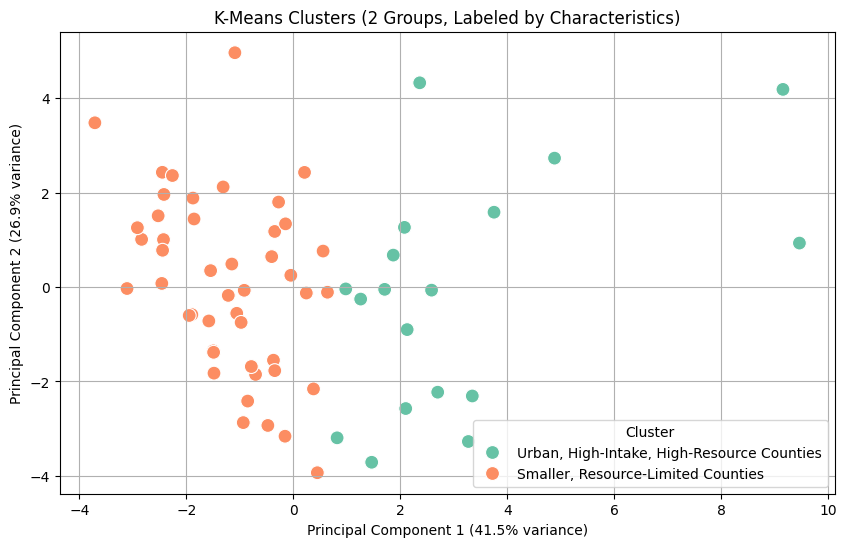

In [13]:
df["cluster_label"] = df["cluster"].map(cluster_labels)


# Plot with descriptive cluster names
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette='Set2', s=100)
plt.title('K-Means Clusters (2 Groups, Labeled by Characteristics)')
plt.xlabel(f"Principal Component 1 ({explained[0]*100:.1f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained[1]*100:.1f}% variance)")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [14]:
cluster_summary = df.groupby("cluster")[features.columns].mean().round(2)
print(cluster_summary)

          intake  adjusted_intake  euthanized  owner_occupied  \
cluster                                                         
0        1802.02          1616.28      609.85        16890.24   
1        4294.11          3762.06      961.17        81716.28   

         renter_occupied  homeownership_rate  rental_rate  total_population  \
cluster                                                                       
0                7404.43                0.71        29.01          61442.57   
1               47502.67                0.67        32.59         331467.56   

         poverty_rate  median_income  snap_percent  health_insurance_percent  \
cluster                                                                        
0               17.19       53550.70         12.89                     88.57   
1               11.69       73406.83          8.01                     90.39   

         uninsured_percent  percent_bachelors_or_higher  unemployment_rate  
cluster                 

In [15]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_features, df['cluster'])
print(f'Silhouette Score: {score:.2f}')


Silhouette Score: 0.27


Silhouette Score of 0.59 indicates a strong well defined clustering, with clear seperation


# Classification Modeling Using Random Forest

## Adoption_Rate

In [16]:
# Step 1: Prepare the data
X = df.select_dtypes(include='number').drop(columns=[
    'adoption_rate', 'euthanasia_rate', 'cluster', 'PC1', 'PC2'
], errors='ignore')  # Features

y = df['adoption_rate_bin']  # Target


In [17]:
# Encode labels (Low = 0, Medium = 1, High = 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [18]:
# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [19]:
# Step 3: Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Step 4: Make predictions
y_pred = clf.predict(X_test)

In [21]:
# Step 5: Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

        High       0.44      0.57      0.50         7
         Low       1.00      0.14      0.25         7
      Medium       0.40      0.67      0.50         6

    accuracy                           0.45        20
   macro avg       0.61      0.46      0.42        20
weighted avg       0.63      0.45      0.41        20



In [22]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[4 0 3]
 [3 1 3]
 [2 0 4]]


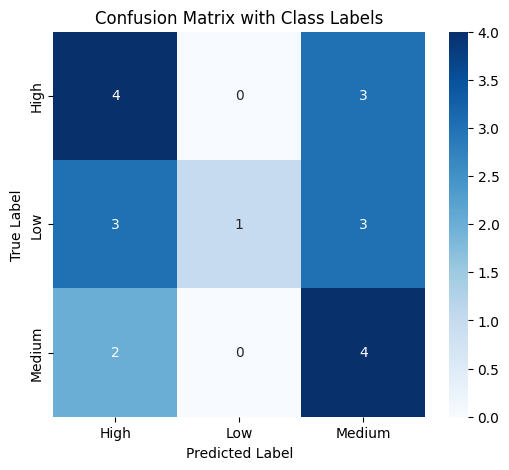

In [23]:
# True labels and predictions already exist: y_test and y_pred
labels = le.classes_

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Class Labels')
plt.show()

##  Confusion Matrix

 Interpretation

High Adoption (Actual High)
- Correctly predicted: 5
- Misclassified as Medium: 2
- Recall: 5 / 7 = 0.71  
- The model performs well at identifying High adoption counties. Most misclassifications happen with Medium.

Low Adoption (Actual Low)
- Correctly predicted: 3
- Misclassified as High: 1
- Misclassified as Medium: 3
- Recall: 3 / 7 = 0.43  
- The model struggles with Low adoption counties and splits predictions between all three classes.

Medium Adoption (Actual Medium)
- Correctly predicted: 4
- Misclassified as High: 2
- **Recall:** 4 / 6 = 0.67  
- The model often confuses Medium with High.

Summary

- Most errors occur between High and Medium adoption categories.
- Low adoption is the hardest class to classify correctly.
- The model does not confuse High and Low directly, which is a good sign — the extremes are relatively distinct.


## Euthanasia_Rate 

In [24]:
# Step 1: Define features and target
X = df.select_dtypes(include='number').drop(columns=[
    'euthanasia_rate', 'euthanasia_rate_bin',
    'adoption_rate', 'adoption_rate_bin',
    'cluster', 'PC1', 'PC2'
], errors='ignore')  # Drop targets & derived columns

y = df["euthanasia_rate_bin"]


In [25]:
# Step 2: Encode target labels
le_euth = LabelEncoder()
y_encoded = le_euth.fit_transform(y)


In [26]:
# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [27]:
# Step 4: Train model
clf_euth = RandomForestClassifier(n_estimators=100, random_state=42)
clf_euth.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
# Step 5: Predict and evaluate
y_pred = clf_euth.predict(X_test)

print("Classification Report (Euthanasia Rate Bin):")
print(classification_report(y_test, y_pred, target_names=le_euth.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report (Euthanasia Rate Bin):
              precision    recall  f1-score   support

        High       0.57      0.57      0.57         7
         Low       0.75      0.43      0.55         7
      Medium       0.33      0.50      0.40         6

    accuracy                           0.50        20
   macro avg       0.55      0.50      0.51        20
weighted avg       0.56      0.50      0.51        20

Confusion Matrix:
[[4 0 3]
 [1 3 3]
 [2 1 3]]


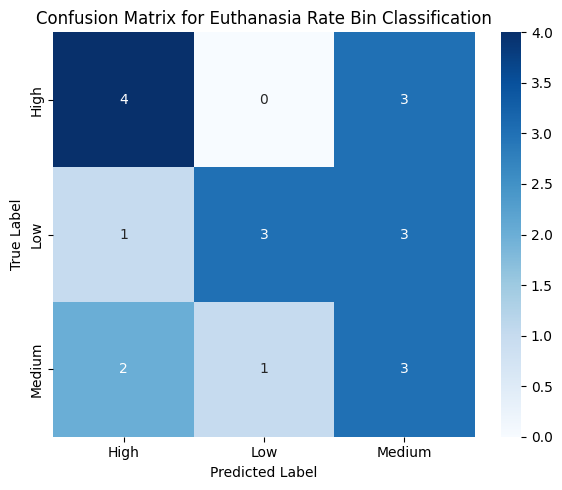

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le_euth.classes_  # This gives you ['High', 'Low', 'Medium'] or whatever order is used

# Step 2: Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)

# Step 3: Label the axes
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Euthanasia Rate Bin Classification")
plt.tight_layout()
plt.show()


# Geospatial Map of Adoption Rate Bins

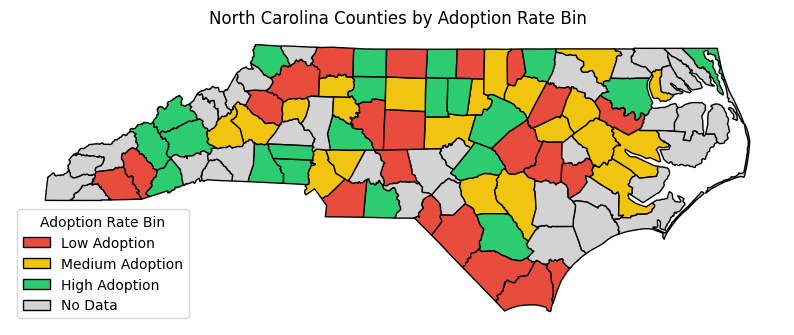

In [30]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Step 1: Load your dataset
df = pd.read_csv("fully_combined.csv")

# Step 2: Create the adoption rate bins (Low, Medium, High)
df["adoption_rate_bin"] = pd.qcut(df["adoption_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 3: Clean county names
df["county"] = df["county"].str.upper().str.replace(" COUNTY", "", regex=False)

# Step 4: Load the shapefile (U.S. counties)
gdf = gpd.read_file("/work/files/cb_2022_us_county_5m.shp")

# Step 5: Filter for North Carolina using FIPS code '37'
nc_counties = gdf[gdf['STATEFP'] == '37'].copy()
nc_counties["NAME"] = nc_counties["NAME"].str.upper()

# Step 6: Merge geospatial data with your dataset
merged = nc_counties.merge(df, left_on="NAME", right_on="county", how="left")

# Step 7: Define custom colors for bins
bin_colors = {
    "Low": "#e74c3c",      # red
    "Medium": "#f1c40f",   # yellow
    "High": "#2ecc71"      # green
}

# Step 8: Assign color to each row, default to 'lightgrey' for missing values
merged["color"] = merged["adoption_rate_bin"].astype(str).map(bin_colors).fillna("lightgrey")

# Step 9: Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(color=merged["color"], ax=ax, edgecolor="black")

# Step 10: Add a custom legend
legend_elements = [
    Patch(facecolor=bin_colors["Low"], edgecolor='black', label='Low Adoption'),
    Patch(facecolor=bin_colors["Medium"], edgecolor='black', label='Medium Adoption'),
    Patch(facecolor=bin_colors["High"], edgecolor='black', label='High Adoption'),
    Patch(facecolor='lightgrey', edgecolor='black', label='No Data')
]
ax.legend(handles=legend_elements, title="Adoption Rate Bin", loc='lower left')

# Step 11: Final formatting
plt.title("North Carolina Counties by Adoption Rate Bin")
plt.axis('off')
plt.show()


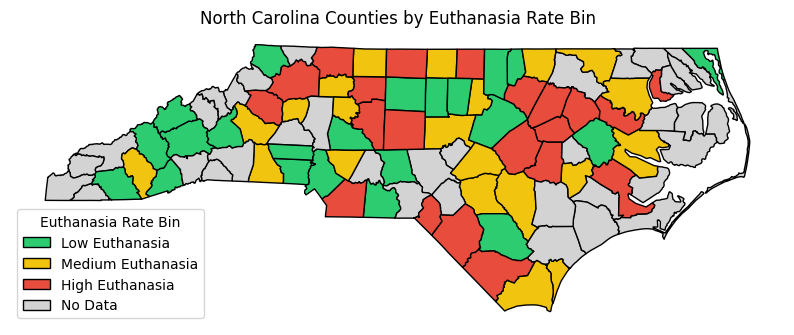

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Step 1: Load your dataset
df = pd.read_csv("fully_combined.csv")

# Step 2: Create the euthanasia rate bins (Low, Medium, High)
df["euthanasia_rate_bin"] = pd.qcut(df["euthanasia_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 3: Clean county names
df["county"] = df["county"].str.upper().str.replace(" COUNTY", "", regex=False)

# Step 4: Load the shapefile (U.S. counties)
gdf = gpd.read_file("/work/files/cb_2022_us_county_5m.shp")

# Step 5: Filter for North Carolina using FIPS code '37'
nc_counties = gdf[gdf['STATEFP'] == '37'].copy()
nc_counties["NAME"] = nc_counties["NAME"].str.upper()

# Step 6: Merge geospatial data with your dataset
merged = nc_counties.merge(df, left_on="NAME", right_on="county", how="left")

# Step 7: Define custom colors for bins
bin_colors = {
    "Low": "#2ecc71",      # green
    "Medium": "#f1c40f",   # yellow
    "High": "#e74c3c"      # red
}

# Step 8: Assign color to each row, default to 'lightgrey' for missing values
merged["color"] = merged["euthanasia_rate_bin"].astype(str).map(bin_colors).fillna("lightgrey")

# Step 9: Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(color=merged["color"], ax=ax, edgecolor="black")

# Step 10: Add a custom legend
legend_elements = [
    Patch(facecolor=bin_colors["Low"], edgecolor='black', label='Low Euthanasia'),
    Patch(facecolor=bin_colors["Medium"], edgecolor='black', label='Medium Euthanasia'),
    Patch(facecolor=bin_colors["High"], edgecolor='black', label='High Euthanasia'),
    Patch(facecolor='lightgrey', edgecolor='black', label='No Data')
]
ax.legend(handles=legend_elements, title="Euthanasia Rate Bin", loc='lower left')

# Step 11: Final formatting
plt.title("North Carolina Counties by Euthanasia Rate Bin")
plt.axis('off')
plt.show()


/tmp/ipykernel_77/279966933.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adopt_summary = df.groupby("adoption_rate_bin")[["poverty_rate", "median_income", "rental_rate", "intake"]].mean().reset_index()
/tmp/ipykernel_77/279966933.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  euth_summary = df.groupby("euthanasia_rate_bin")[["poverty_rate", "median_income", "rental_rate", "intake"]].mean().reset_index()
/tmp/ipykernel_77/279966933.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` 

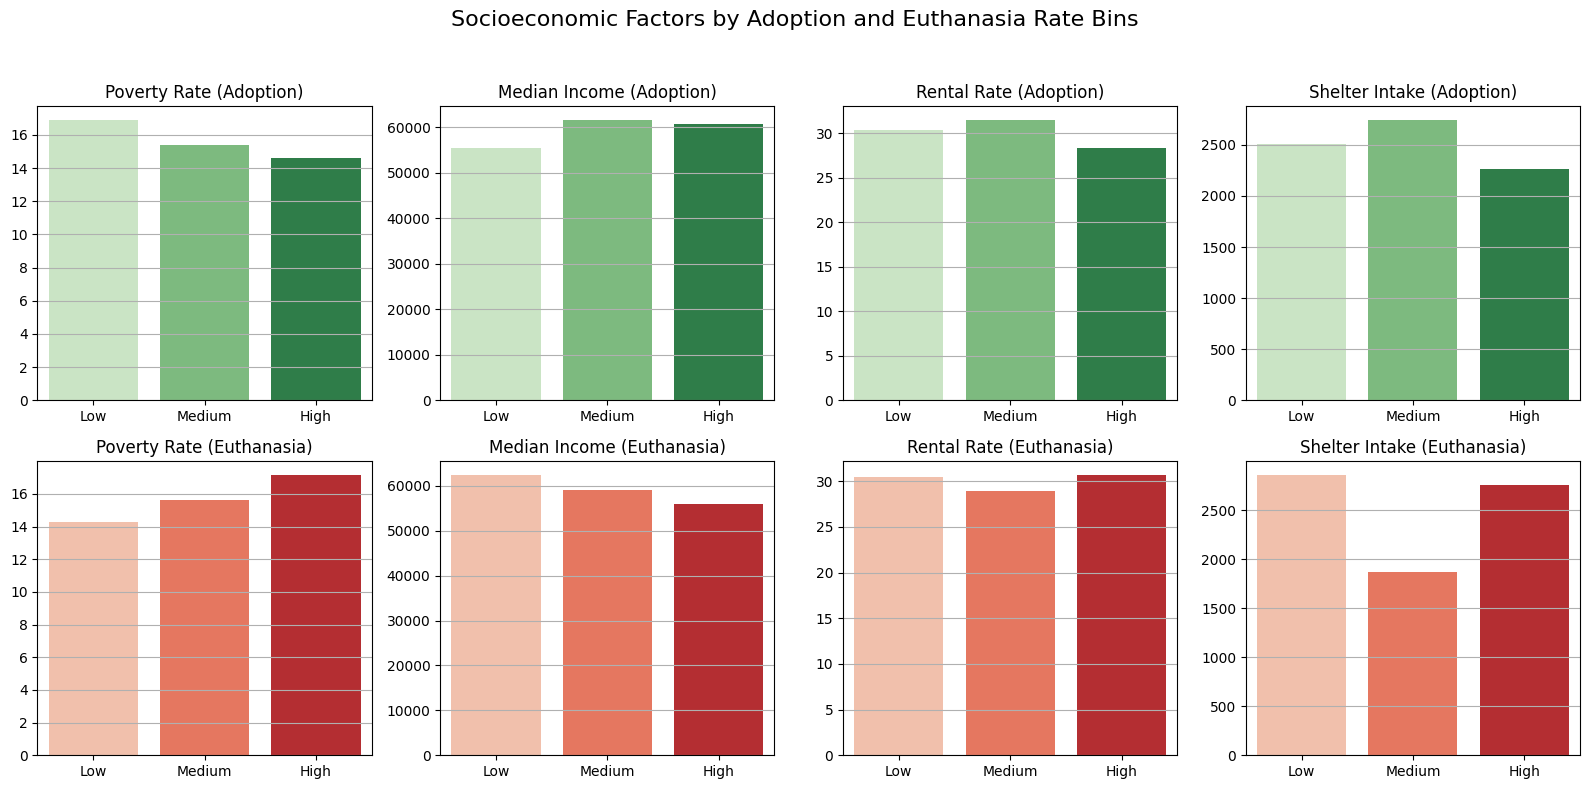

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure adoption and euthanasia bins are defined
df["adoption_rate_bin"] = pd.qcut(df["adoption_rate"], q=3, labels=["Low", "Medium", "High"])
df["euthanasia_rate_bin"] = pd.qcut(df["euthanasia_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 1: Get summaries
adopt_summary = df.groupby("adoption_rate_bin")[["poverty_rate", "median_income", "rental_rate", "intake"]].mean().reset_index()
euth_summary = df.groupby("euthanasia_rate_bin")[["poverty_rate", "median_income", "rental_rate", "intake"]].mean().reset_index()

# Step 2: Setup figure
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Socioeconomic Factors by Adoption and Euthanasia Rate Bins", fontsize=16)

# Define order if needed
order = ["Low", "Medium", "High"]

# Step 3: Plot adoption (top row)
sns.barplot(data=adopt_summary, x="adoption_rate_bin", y="poverty_rate", ax=axs[0, 0], palette="Greens", order=order)
axs[0, 0].set_title("Poverty Rate (Adoption)")
axs[0, 0].set_xlabel("")

sns.barplot(data=adopt_summary, x="adoption_rate_bin", y="median_income", ax=axs[0, 1], palette="Greens", order=order)
axs[0, 1].set_title("Median Income (Adoption)")
axs[0, 1].set_xlabel("")

sns.barplot(data=adopt_summary, x="adoption_rate_bin", y="rental_rate", ax=axs[0, 2], palette="Greens", order=order)
axs[0, 2].set_title("Rental Rate (Adoption)")
axs[0, 2].set_xlabel("")

sns.barplot(data=adopt_summary, x="adoption_rate_bin", y="intake", ax=axs[0, 3], palette="Greens", order=order)
axs[0, 3].set_title("Shelter Intake (Adoption)")
axs[0, 3].set_xlabel("")

# Step 4: Plot euthanasia (bottom row)
sns.barplot(data=euth_summary, x="euthanasia_rate_bin", y="poverty_rate", ax=axs[1, 0], palette="Reds", order=order)
axs[1, 0].set_title("Poverty Rate (Euthanasia)")
axs[1, 0].set_xlabel("")

sns.barplot(data=euth_summary, x="euthanasia_rate_bin", y="median_income", ax=axs[1, 1], palette="Reds", order=order)
axs[1, 1].set_title("Median Income (Euthanasia)")
axs[1, 1].set_xlabel("")

sns.barplot(data=euth_summary, x="euthanasia_rate_bin", y="rental_rate", ax=axs[1, 2], palette="Reds", order=order)
axs[1, 2].set_title("Rental Rate (Euthanasia)")
axs[1, 2].set_xlabel("")

sns.barplot(data=euth_summary, x="euthanasia_rate_bin", y="intake", ax=axs[1, 3], palette="Reds", order=order)
axs[1, 3].set_title("Shelter Intake (Euthanasia)")
axs[1, 3].set_xlabel("")

# Style tweaks
for ax in axs.flat:
    ax.set_ylabel("")
    ax.grid(True, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


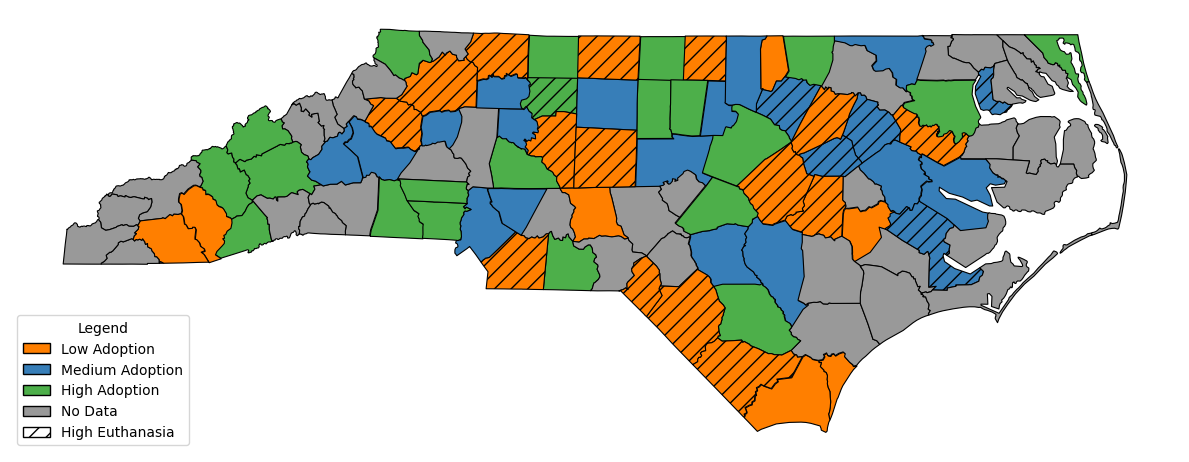

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Step 1: Load your dataset
df = pd.read_csv("fully_combined.csv")

# Step 2: Create the adoption rate bins
df["adoption_rate_bin"] = pd.qcut(df["adoption_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 3: Clean county names
df["county"] = df["county"].str.upper().str.replace(" COUNTY", "", regex=False)

# Step 4: Load the shapefile (U.S. counties)
gdf = gpd.read_file("/work/files/cb_2022_us_county_5m.shp")

# Step 5: Filter for North Carolina counties
nc_counties = gdf[gdf['STATEFP'] == '37'].copy()
nc_counties["NAME"] = nc_counties["NAME"].str.upper()

# Step 6: Merge with data
merged = nc_counties.merge(df, left_on="NAME", right_on="county", how="left")

# Step 7: Define CB-friendly fill colors for adoption rates
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
bin_colors = {
    "Low": CB_color_cycle[1],     # orange
    "Medium": CB_color_cycle[0],  # blue
    "High": CB_color_cycle[2]     # green
}
merged["fill_color"] = merged["adoption_rate_bin"].astype(str).map(bin_colors).fillna("#999999")

# Step 8: Bin euthanasia rates
merged["euthanasia_bin"] = pd.qcut(merged["euthanasia_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 9: Hatch only High euthanasia
hatch_map = {
    "Low": '',          # no hatch
    "Medium": None,     # no visual encoding
    "High": '//'        # diagonal lines for High
}
merged["hatch_pattern"] = merged["euthanasia_bin"].map(hatch_map).fillna('')

# Step 10: Plot each county with color and selective hatching
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

for _, row in merged.iterrows():
    merged.loc[[_]].plot(
        ax=ax,
        color=row["fill_color"],
        edgecolor="black",
        hatch=row["hatch_pattern"] if row["euthanasia_bin"] != "Medium" else None,
        linewidth=0.8
    )

# Step 11: Custom legend
adoption_patches = [
    Patch(facecolor=bin_colors["Low"], edgecolor='black', label='Low Adoption'),
    Patch(facecolor=bin_colors["Medium"], edgecolor='black', label='Medium Adoption'),
    Patch(facecolor=bin_colors["High"], edgecolor='black', label='High Adoption'),
    Patch(facecolor="#999999", edgecolor='black', label='No Data')
]

euthanasia_patches = [
    Patch(facecolor='white', edgecolor='black', hatch='//', label='High Euthanasia')
]

ax.legend(handles=adoption_patches + euthanasia_patches, title="Legend", loc='lower left')

# Final formatting
plt.axis('off')
plt.tight_layout()
plt.show()


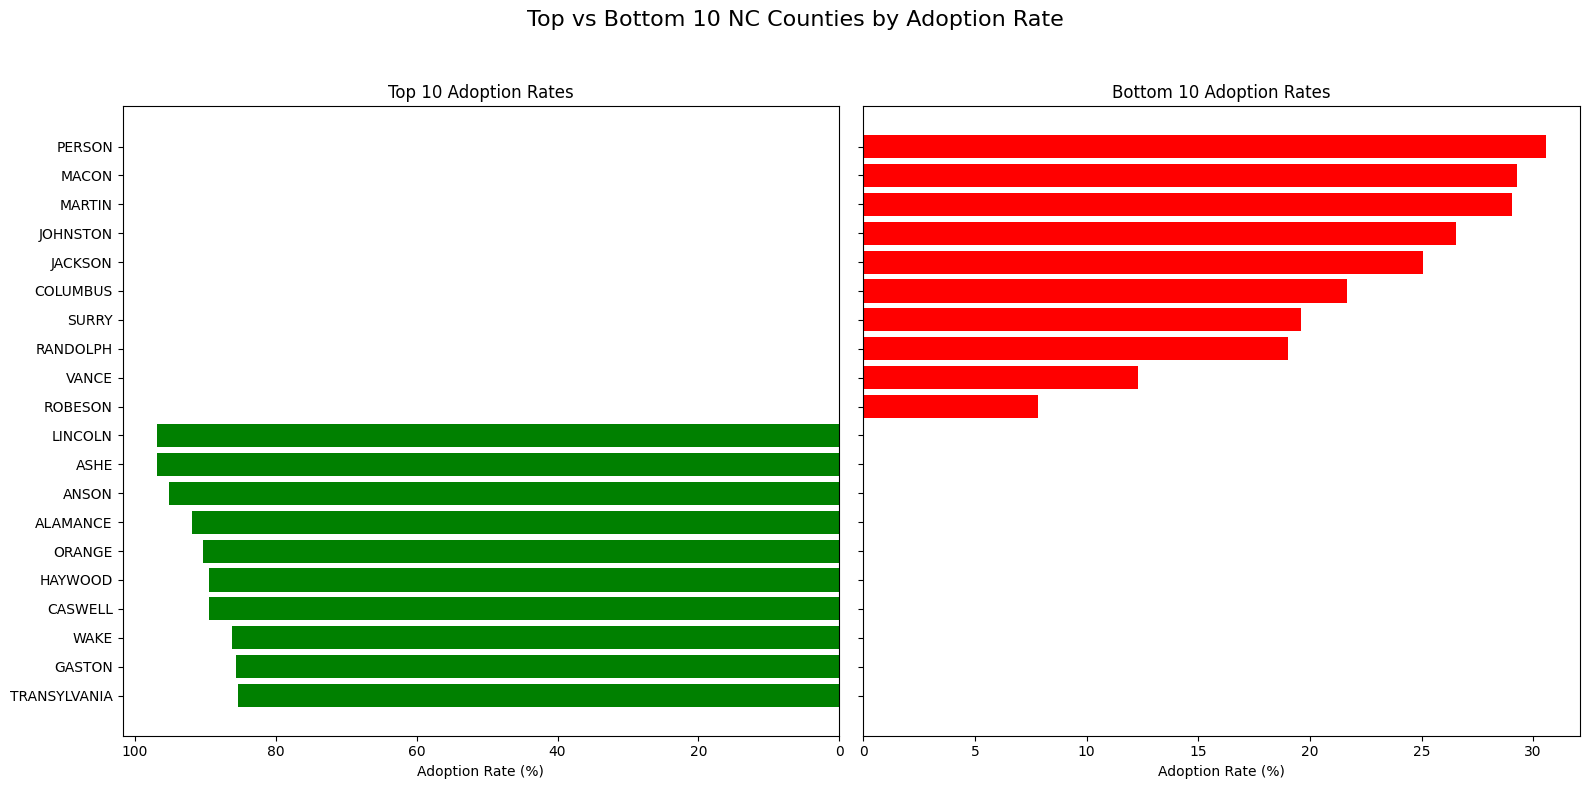

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("fully_combined.csv")

# Get Top 10 and Bottom 10 counties by adoption rate
top_10 = df[['county', 'adoption_rate']].nlargest(10, 'adoption_rate')
bottom_10 = df[['county', 'adoption_rate']].nsmallest(10, 'adoption_rate')

# Sort them for cleaner bar chart display
top_10 = top_10.sort_values('adoption_rate')
bottom_10 = bottom_10.sort_values('adoption_rate')

# Plot side-by-side horizontal bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
fig.suptitle("Top vs Bottom 10 NC Counties by Adoption Rate", fontsize=16)

# Top 10
axes[0].barh(top_10['county'], top_10['adoption_rate'], color='green')
axes[0].set_title('Top 10 Adoption Rates')
axes[0].invert_xaxis()
axes[0].set_xlabel('Adoption Rate (%)')

# Bottom 10
axes[1].barh(bottom_10['county'], bottom_10['adoption_rate'], color='red')
axes[1].set_title('Bottom 10 Adoption Rates')
axes[1].set_xlabel('Adoption Rate (%)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

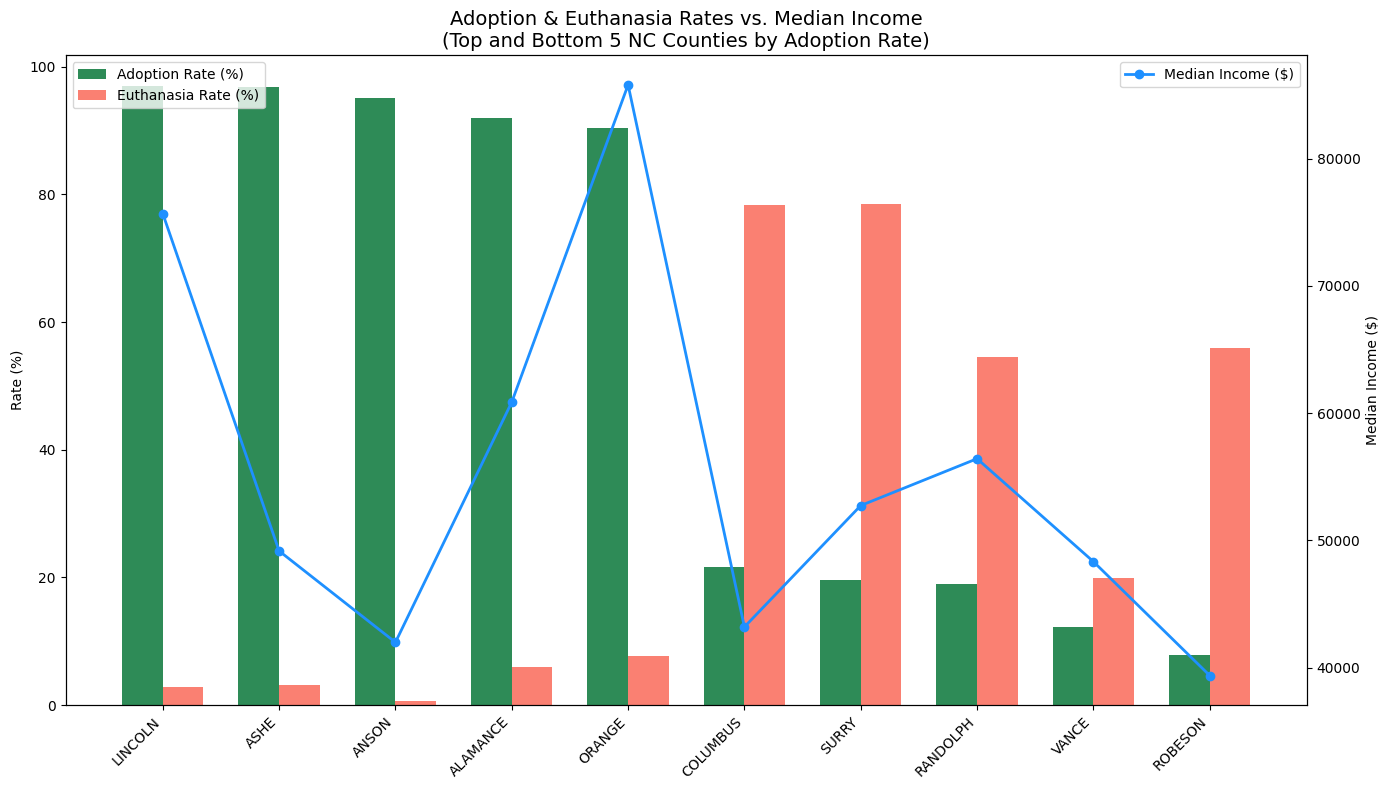

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("fully_combined.csv")  # Adjust path if needed

# Get top and bottom 5 counties by adoption rate for clean spacing
top_5 = df[['county', 'adoption_rate', 'euthanasia_rate', 'median_income']].nlargest(5, 'adoption_rate')
bottom_5 = df[['county', 'adoption_rate', 'euthanasia_rate', 'median_income']].nsmallest(5, 'adoption_rate')

# Combine and create a flag
top_5['Group'] = 'Top 5'
bottom_5['Group'] = 'Bottom 5'
combined = pd.concat([top_5, bottom_5])
combined = combined.sort_values(by='adoption_rate', ascending=False)

# Set positions for grouped bars
counties = combined['county']
x = np.arange(len(counties))
width = 0.35

# Plot setup
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()  # Secondary axis for median income

# Bar plots for adoption and euthanasia rates
bars1 = ax1.bar(x - width/2, combined['adoption_rate'], width, label='Adoption Rate (%)', color='seagreen')
bars2 = ax1.bar(x + width/2, combined['euthanasia_rate'], width, label='Euthanasia Rate (%)', color='salmon')

# Line plot for median income
ax2.plot(x, combined['median_income'], color='dodgerblue', marker='o', label='Median Income ($)', linewidth=2)

# Axis formatting
ax1.set_ylabel('Rate (%)')
ax2.set_ylabel('Median Income ($)')
ax1.set_title('Adoption & Euthanasia Rates vs. Median Income\n(Top and Bottom 5 NC Counties by Adoption Rate)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(counties, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


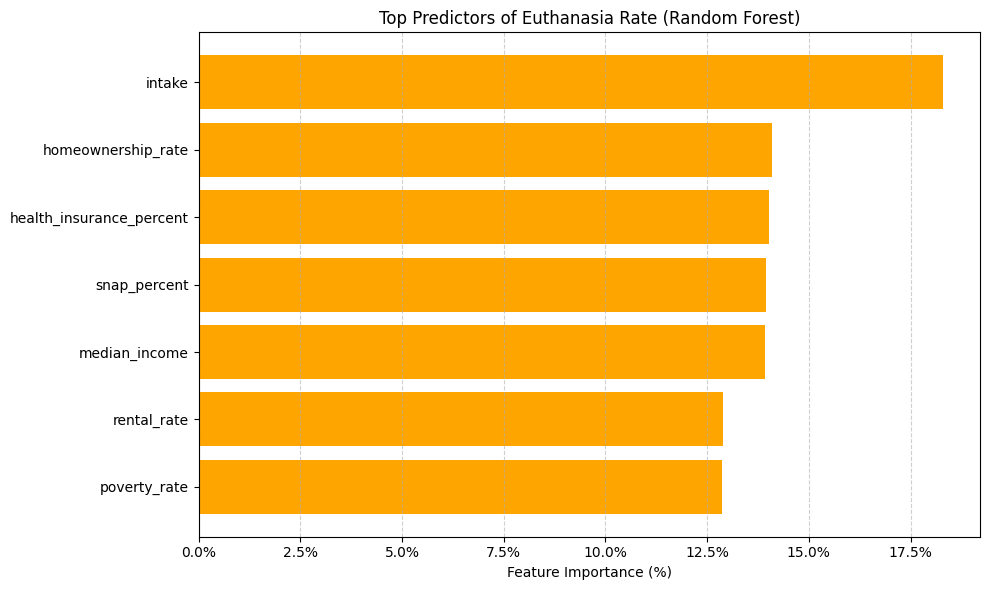

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report

# Load your dataset
df = pd.read_csv("fully_combined.csv")

# Drop missing values
df_clean = df.dropna()

# Select predictor features
features = [
    'poverty_rate', 'rental_rate', 'median_income', 'homeownership_rate',
    'health_insurance_percent', 'snap_percent', 'intake'
]
X = df_clean[features]

# Target: Euthanasia rate binned into categories
y = df_clean['euthanasia_rate']
kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
y_binned = kb.fit_transform(y.values.reshape(-1, 1)).astype(int).ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binned, test_size=0.2, random_state=42
)

# Train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='orange')
plt.xlabel("Feature Importance (%)")
plt.title("Top Predictors of Euthanasia Rate (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()



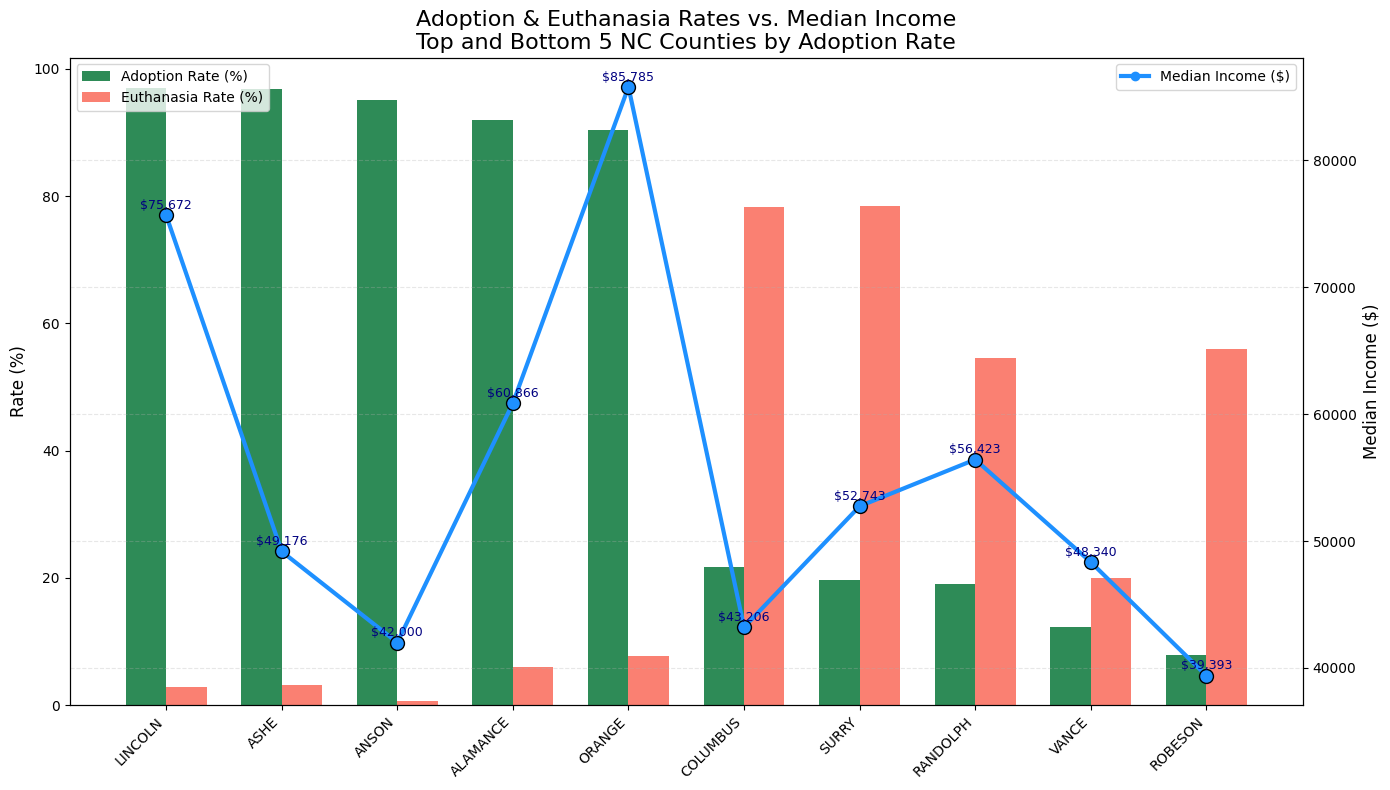

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("fully_combined.csv")  # Adjust path if needed

# Get top and bottom 5 counties by adoption rate
top_5 = df[['county', 'adoption_rate', 'euthanasia_rate', 'median_income']].nlargest(5, 'adoption_rate')
bottom_5 = df[['county', 'adoption_rate', 'euthanasia_rate', 'median_income']].nsmallest(5, 'adoption_rate')

# Combine and label
top_5['Group'] = 'Top 5'
bottom_5['Group'] = 'Bottom 5'
combined = pd.concat([top_5, bottom_5])
combined = combined.sort_values(by='adoption_rate', ascending=False)

# Setup
counties = combined['county']
x = np.arange(len(counties))
width = 0.35

# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Bar plots
bars1 = ax1.bar(x - width/2, combined['adoption_rate'], width, label='Adoption Rate (%)', color='seagreen')
bars2 = ax1.bar(x + width/2, combined['euthanasia_rate'], width, label='Euthanasia Rate (%)', color='salmon')

# Line plot with enhanced styling
ax2.plot(x, combined['median_income'], color='dodgerblue', marker='o', linewidth=3, label='Median Income ($)', zorder=5)
ax2.scatter(x, combined['median_income'], color='dodgerblue', edgecolors='black', s=100, zorder=6)

# Add labels above line points
for i, income in enumerate(combined['median_income']):
    ax2.text(x[i], income + 500, f"${int(income):,}", color='navy', ha='center', fontsize=9, zorder=7)

# Axes and titles
ax1.set_ylabel('Rate (%)', fontsize=12)
ax2.set_ylabel('Median Income ($)', fontsize=12)
ax1.set_title('Adoption & Euthanasia Rates vs. Median Income\nTop and Bottom 5 NC Counties by Adoption Rate', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(counties, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Improve grid and layout
ax2.grid(visible=True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


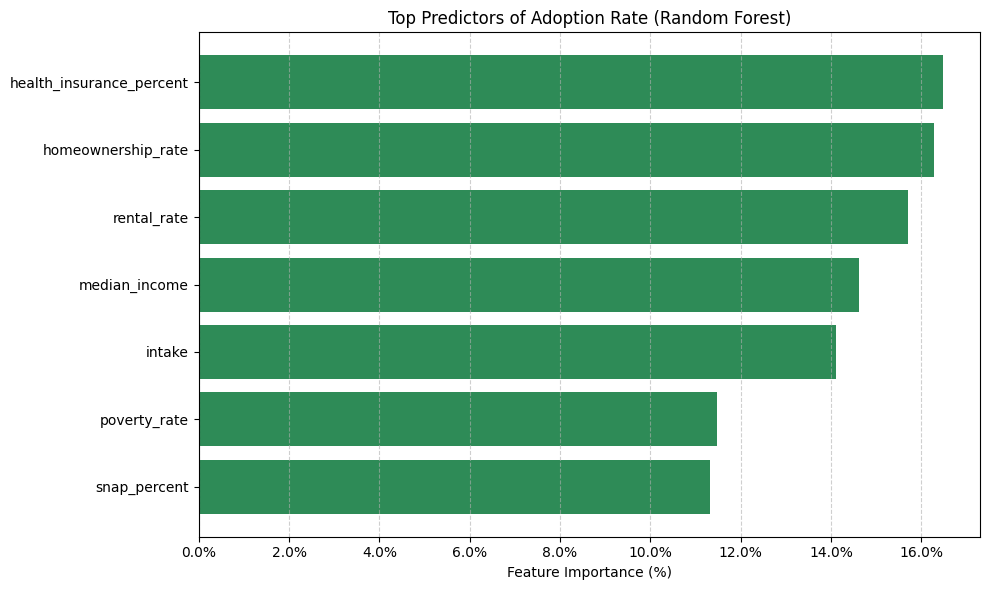

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("fully_combined.csv")

# Drop missing values
df_clean = df.dropna()

# Predictor features
features = [
    'poverty_rate', 'rental_rate', 'median_income', 'homeownership_rate',
    'health_insurance_percent', 'snap_percent', 'intake'
]
X = df_clean[features]

# Target: Adoption rate binned into 3 categories (low, medium, high)
y = df_clean['adoption_rate']
kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
y_binned = kb.fit_transform(y.values.reshape(-1, 1)).astype(int).ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binned, test_size=0.2, random_state=42
)

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='seagreen')
plt.xlabel("Feature Importance (%)")
plt.title("Top Predictors of Adoption Rate (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()


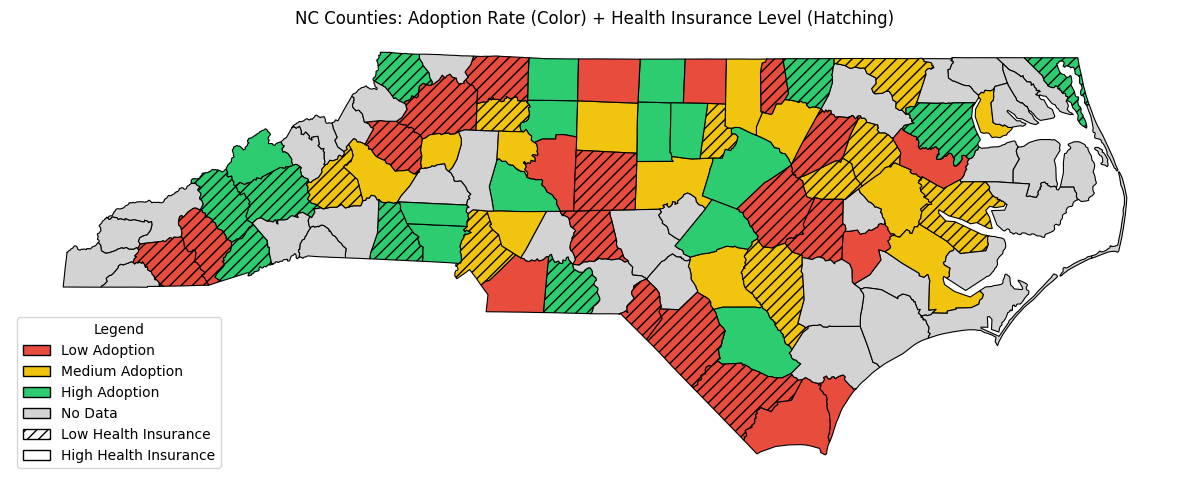

In [79]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Step 1: Load your dataset
df = pd.read_csv("fully_combined.csv")

# Step 2: Create adoption rate bins
df["adoption_rate_bin"] = pd.qcut(df["adoption_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 3: Clean county names
df["county"] = df["county"].str.upper().str.replace(" COUNTY", "", regex=False)

# Step 4: Load shapefile and filter for NC
gdf = gpd.read_file("/work/files/cb_2022_us_county_5m.shp")
nc_counties = gdf[gdf['STATEFP'] == '37'].copy()
nc_counties["NAME"] = nc_counties["NAME"].str.upper()

# Step 5: Merge with dataset
merged = nc_counties.merge(df, left_on="NAME", right_on="county", how="left")

# Step 6: Color fill for adoption rate
bin_colors = {
    "Low": "#e74c3c",     # red
    "Medium": "#f1c40f",  # yellow
    "High": "#2ecc71"     # green
}
merged["fill_color"] = merged["adoption_rate_bin"].astype(str).map(bin_colors).fillna("lightgrey")

# Step 7: Health Insurance binning and hatching
# Bin health insurance percentage into Low and High categories
merged["health_insurance_bin"] = pd.qcut(merged["health_insurance_percent"], q=2, labels=["Low", "High"])

# Map hatch patterns based on health insurance percent
hatch_map = {"Low": "///", "High": ""}
merged["hatch"] = merged["health_insurance_bin"].map(hatch_map)

# Step 8: Plot map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

for _, row in merged.iterrows():
    hatch = row["hatch"] if pd.notna(row["hatch"]) else ''
    merged.loc[[row.name]].plot(
        ax=ax,
        facecolor=row["fill_color"],
        edgecolor="black",
        hatch=hatch,
        linewidth=0.8
    )

# Step 9: Legend
legend_elements = [
    # Adoption rate
    Patch(facecolor=bin_colors["Low"], edgecolor='black', label='Low Adoption'),
    Patch(facecolor=bin_colors["Medium"], edgecolor='black', label='Medium Adoption'),
    Patch(facecolor=bin_colors["High"], edgecolor='black', label='High Adoption'),
    Patch(facecolor='lightgrey', edgecolor='black', label='No Data'),

    # Health insurance percentage
    Patch(facecolor='white', edgecolor='black', hatch='///', label='Low Health Insurance'),
    Patch(facecolor='white', edgecolor='black', hatch='', label='High Health Insurance')
]

ax.legend(handles=legend_elements, title="Legend", loc='lower left')

# Step 10: Final touches
plt.title("NC Counties: Adoption Rate (Color) + Health Insurance Level (Hatching)")
plt.axis('off')
plt.tight_layout()
plt.show()



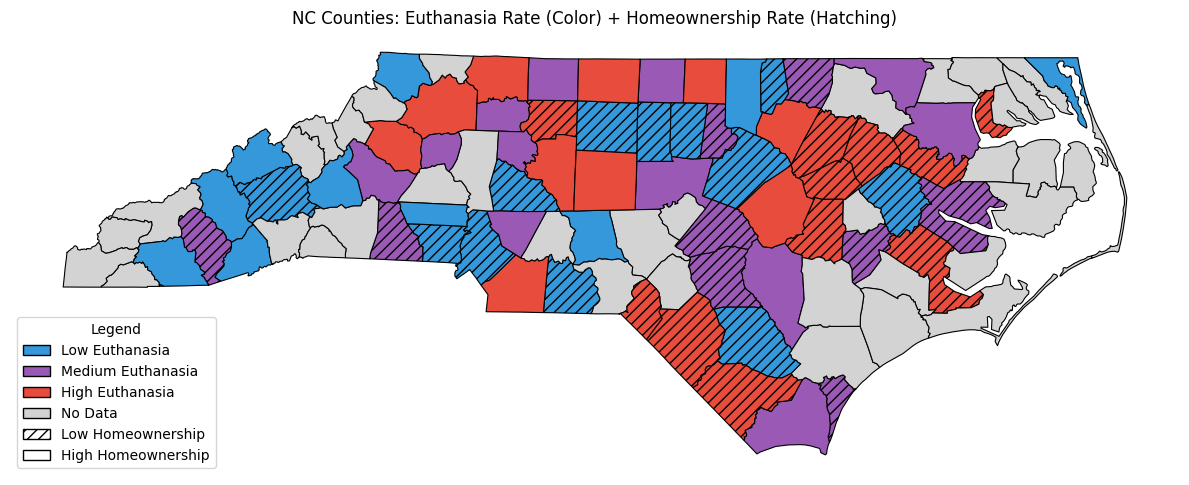

In [73]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Step 1: Load your dataset
df = pd.read_csv("fully_combined.csv")

# Step 2: Create euthanasia rate bins
df["euthanasia_rate_bin"] = pd.qcut(df["euthanasia_rate"], q=3, labels=["Low", "Medium", "High"])

# Step 3: Clean county names
df["county"] = df["county"].str.upper().str.replace(" COUNTY", "", regex=False)

# Step 4: Load shapefile and filter for NC
gdf = gpd.read_file("/work/files/cb_2022_us_county_5m.shp")
nc_counties = gdf[gdf['STATEFP'] == '37'].copy()
nc_counties["NAME"] = nc_counties["NAME"].str.upper()

# Step 5: Merge with dataset
merged = nc_counties.merge(df, left_on="NAME", right_on="county", how="left")

# Step 6: Color fill for euthanasia rate
bin_colors = {
    "Low": "#3498db",     # blue
    "Medium": "#9b59b6",  # purple
    "High": "#e74c3c"     # red
}
merged["fill_color"] = merged["euthanasia_rate_bin"].astype(str).map(bin_colors).fillna("lightgrey")

# Step 7: Homeownership rate binning and hatching
# Bin homeownership rate into Low and High categories
merged["homeownership_bin"] = pd.qcut(merged["homeownership_rate"], q=2, labels=["Low", "High"])

# Map hatch patterns based on homeownership rate
hatch_map = {"Low": "///", "High": ""}
merged["hatch"] = merged["homeownership_bin"].map(hatch_map)

# Step 8: Plot map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

for _, row in merged.iterrows():
    hatch = row["hatch"] if pd.notna(row["hatch"]) else ''
    merged.loc[[row.name]].plot(
        ax=ax,
        facecolor=row["fill_color"],
        edgecolor="black",
        hatch=hatch,
        linewidth=0.8
    )

# Step 9: Legend
legend_elements = [
    # Euthanasia rate
    Patch(facecolor=bin_colors["Low"], edgecolor='black', label='Low Euthanasia'),
    Patch(facecolor=bin_colors["Medium"], edgecolor='black', label='Medium Euthanasia'),
    Patch(facecolor=bin_colors["High"], edgecolor='black', label='High Euthanasia'),
    Patch(facecolor='lightgrey', edgecolor='black', label='No Data'),

    # Homeownership rate
    Patch(facecolor='white', edgecolor='black', hatch='///', label='Low Homeownership'),
    Patch(facecolor='white', edgecolor='black', hatch='', label='High Homeownership')
]

ax.legend(handles=legend_elements, title="Legend", loc='lower left')

# Step 10: Final touches
plt.title("NC Counties: Euthanasia Rate (Color) + Homeownership Rate (Hatching)")
plt.axis('off')
plt.tight_layout()
plt.show()
